In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# This line is for displaying our graphs in Jupyter
%matplotlib inline
sns.set()

import datetime

import math

In [2]:
def PCC(dataframe: pd, features: list, target: str):
    r_values = []
    
    y_values = dataframe[target].to_numpy()
    y_mean = y_values.mean()
    
    for column in features:
        x_values = dataframe[column].to_numpy()
        x_mean = x_values.mean()
        numerator = sum((x_values - x_mean) * (y_values- y_mean))
        denominator = np.sqrt(sum((x_values - x_mean)**2) * sum((y_values - y_mean)**2))
        
        r = numerator / denominator
        r_values.append(r)
    
    return r_values

In [3]:
def kernelize(df: pd, features: list, value):
    dataframe = df.copy()
    if type(value) is list:
        for i in range(len(features)):
            dataframe[features[i]] = dataframe[features[i]] ** value[i]
    
    else:
        for column in features:
            dataframe[column] = dataframe[column] ** value
    
    return dataframe

In [4]:
def MSE(y_pred_values, y_values, data_length):
    
    sum_error = sum((y_pred_values - y_values) ** 2)
    
    cost = (1 / data_length) * sum_error
    
    return cost

In [5]:
def LinearRegression(dataframe: pd, 
                     features: list,
                     target: str,
                     rate = 0.00001,
                     epochs = 1000
                    ):
    
    # x_values contains the values of the entire column of "x_column"
    # y_values contains the values of the entire column of "y_column"
    x_values = dataframe[features]
    y_values = dataframe[target]
    
    
    # Just getting the full length of the dataframe
    total_rows = len(dataframe)
    total_columns = len(features)
    
    # Setting up weight and bias
    weights = np.zeros(total_columns)
    bias = 0
    
    # MSE array that will keep the last cost error (just one value)
    mse_array = []
    
    
    # Gradient descent portion
    for i in range(epochs):
        # pred_y_values is a new column, where the m'x+b' formula has been applied
        # Every row in pred_y_values has the formula applied
        pred_y_values = np.dot(x_values, weights) + bias
        
        # Obtaining the partial derivatives of the weight and bias
        der_weight = (1 / total_rows) * (2 * np.dot(x_values.T, (pred_y_values - y_values)))
        der_bias = (1 / total_rows) * (2 * np.sum(pred_y_values - y_values))
        
        # Calculating the new_weight and new bias
        new_weights = weights - rate * der_weight
        new_bias = bias - rate * der_bias
        
        # Helps prevent infinite values by stopping if MSE increased
        if mse_array == []:
            mse_array.append(MSE(pred_y_values, y_values, total_rows))
        else:
            mse = MSE(pred_y_values, y_values, total_rows)
            if mse > mse_array[0]:
                return (weights, bias)
            else:
                mse_array[0] = mse
                weights = new_weights
                bias = new_bias
        
    return (weights, bias)

In [6]:
def predict(df: pd, features: list, weights: list, bias: int, new_column_name = "Prediction"):
    dataframe = df.copy()
    x_values = dataframe[features].to_numpy()
    dataframe[new_column_name] = np.dot(x_values, weights) + bias
    return dataframe

In [7]:
def performanceAvg(df, y_column, y_pred_column):
    return np.sum((df[y_column] - df[y_pred_column]) ** 2) / len(df)

In [8]:
def expandShiftRight(df, column, length, fillna_values=[]):
    new_df = df.copy()
    column_names = list(df.columns.values)
    
    new_df[column + "0"] = new_df[column]
    
    for i in range(length):
        new_df[column + str(i + 1)] = new_df[column + str(i)].shift(1)
        if fillna_values != []:
            new_df.fillna(fillna_values[i])
        
    new_df = new_df.drop(columns=[column + "0"])
    new_df = new_df.dropna()
    return new_df

In [9]:
def meanRightShift(df, start_col, end_col):
    
    
    pos = df.columns.get_loc(start_col)
    end_pos = df.columns.get_loc(end_col) + 1

    mean_list = []
    
    while (pos + 1 <= end_pos):
        mean = df.iloc[0:1, pos:end_pos].mean(axis=1)[-1:].values[0]
        mean_list.append(mean)
        pos += 1
    
    return mean_list

In [10]:
def rightShift(df, start_col, shift_length, fillna_val):
    new_df = df.copy()
    start_pos = df.columns.get_loc(start_col)
    pos = 0
    while pos <= shift_length:
        mean = fillna_val[pos]
        new_df.iloc[pos + 1: pos + 2, start_pos:] = new_df.iloc[pos:pos + 1, start_pos:].shift(1, axis = 1)
        new_df.iloc[pos + 1: pos + 2, start_pos:] = new_df.iloc[pos + 1: pos + 2, start_pos:].fillna(mean)
        pos += 1
    return new_df

In [11]:
def latestRateOfChange(df, column, period):
    return df[column].pct_change(periods = period)[-1:].values[0]

### Loading data

In [12]:
# Creating a dataframe with stock data
stock_df = pd.read_csv("stock data/BB.csv")

# Taking a peak at the first 5 rows of our table
stock_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-16,3.76,4.10,3.75,4.01,4.01,8747500
1,2020-04-17,4.17,4.29,4.11,4.27,4.27,7456600
2,2020-04-20,4.22,4.32,4.02,4.09,4.09,5220500
3,2020-04-21,4.00,4.15,3.91,3.92,3.92,4442000
4,2020-04-22,4.00,4.06,3.87,3.90,3.90,4221000


In [13]:
# Checking if the Date column is a "datetime" object 
stock_df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [14]:
# It is not, so we convert it to one
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

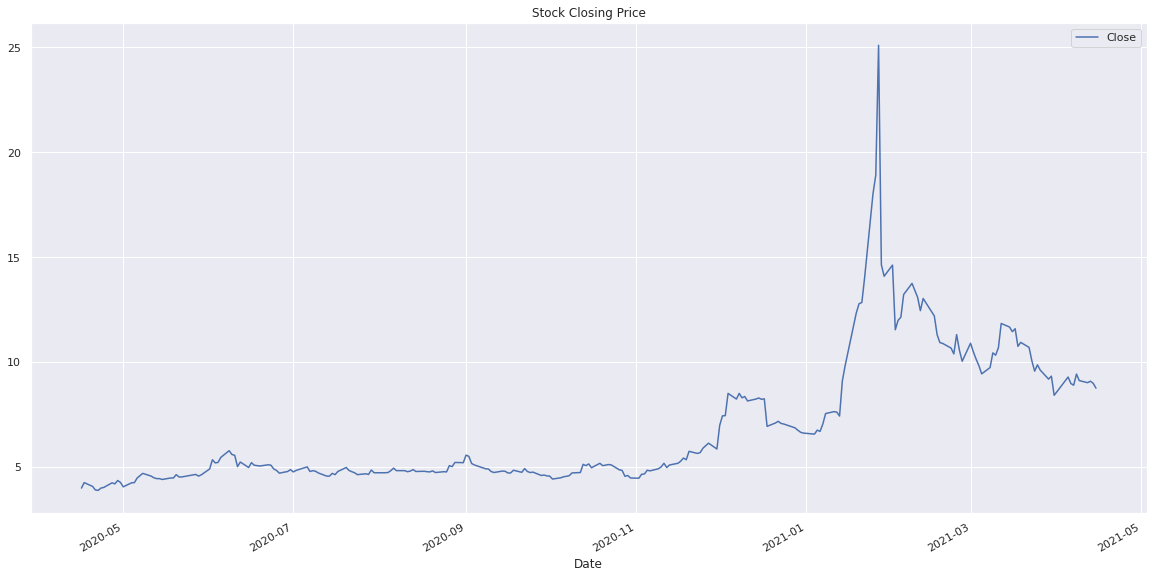

In [15]:
# Plotting Closing Price
stock_df.plot(x="Date",
            y="Close",
            figsize=(20,10),
            title = "Stock Closing Price"
           )
plt.show()

### Creating new features

In [16]:
# Removing unnecessary columns
modified_df = stock_df.copy()
modified_df = modified_df[["Date", "Close"]]
modified_df.head()

,Date,Close
0,2020-04-16,4.01
1,2020-04-17,4.27
2,2020-04-20,4.09
3,2020-04-21,3.92
4,2020-04-22,3.90


In [17]:
# Creating new Close columns
period = 15

modified_df = expandShiftRight(modified_df, "Close", period)
modified_df

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
15,2020-05-07,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09,4.27,4.01
16,2020-05-08,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09,4.27
17,2020-05-11,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09
18,2020-05-12,4.50,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92
19,2020-05-13,4.46,4.50,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,2021-04-09,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76
248,2021-04-12,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95
249,2021-04-13,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71
250,2021-04-14,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07


In [18]:
# Obtaining last 40 stocks (since model performs better with recent data)
# modified_df = modified_df[-40:]
# modified_df = modified_df.reset_index(drop=True)

In [19]:
modified_df.shape

(237, 17)

In [20]:
modified_df.head()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
15,2020-05-07,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09,4.27,4.01
16,2020-05-08,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09,4.27
17,2020-05-11,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92,4.09
18,2020-05-12,4.50,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90,3.92
19,2020-05-13,4.46,4.50,4.58,4.71,4.60,4.49,4.27,4.26,4.07,4.28,4.37,4.21,4.26,4.04,4.01,3.90


In [21]:
modified_df.tail()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
247,2021-04-09,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76
248,2021-04-12,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95
249,2021-04-13,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71
250,2021-04-14,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07
251,2021-04-15,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58


### Spliting into train and test sets

In [22]:
train_df = modified_df[period * 2:-period]
train_df.tail()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
232,2021-03-18,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84,10.15,10.50,10.91,10.05,10.58
233,2021-03-19,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84,10.15,10.50,10.91,10.05
234,2021-03-22,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84,10.15,10.50,10.91
235,2021-03-23,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84,10.15,10.50
236,2021-03-24,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84,10.15


In [23]:
features = list(train_df.columns.values)
features.remove("Date")
features.remove("Close")
features

['Close1',
 'Close2',
 'Close3',
 'Close4',
 'Close5',
 'Close6',
 'Close7',
 'Close8',
 'Close9',
 'Close10',
 'Close11',
 'Close12',
 'Close13',
 'Close14',
 'Close15']

In [24]:
target = "Close"

In [25]:
r_values = PCC(train_df, features, target)
print(f"R-value per feature BEFORE kernelazation: {r_values}")

R-value per feature BEFORE kernelazation: [0.9521490790743546, 0.9252015149079211, 0.8913055902245431, 0.8543945927488904, 0.8303499123672811, 0.8015641025439545, 0.7735805410894914, 0.7551924368024031, 0.734512657420168, 0.71635141006132, 0.6965791263918629, 0.6803571320007409, 0.6593433655346933, 0.6385874485226062, 0.6188779858736446]


In [26]:
# roc = latestRateOfChange(train_df, "Close", period = 15)
# roc = 1 + roc

In [27]:
# Kernelizing features with values above

# train_df = kernelize(train_df, features, roc)
train_df = kernelize(train_df, features, r_values)

In [28]:
train_df

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
45,2020-06-19,5.06,4.699888,4.514867,4.361780,3.948693,3.962636,3.650495,3.775540,3.677995,3.632428,3.377989,3.165871,3.074013,3.025311,2.766179,2.585195
46,2020-06-22,5.12,4.682268,4.498484,4.272295,4.103683,3.798986,3.777929,3.489148,3.658173,3.549136,3.518405,3.266379,3.082036,2.969219,2.921699,2.680661
47,2020-06-23,5.10,4.735117,4.482096,4.257359,4.022945,3.943825,3.627207,3.606627,3.387028,3.530531,3.439700,3.398333,3.177569,2.976729,2.869218,2.826598
48,2020-06-24,4.92,4.717504,4.531246,4.242416,4.009462,3.868395,3.760615,3.467664,3.498315,3.275749,3.422114,3.324389,3.302888,3.066105,2.876247,2.777379
49,2020-06-25,4.85,4.558836,4.514867,4.287225,3.995972,3.855794,3.691160,3.590674,3.366668,3.380385,3.181041,3.307860,3.232676,3.183223,2.959848,2.783972
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232,2021-03-18,10.76,10.316270,9.549029,8.941652,8.267594,7.157292,6.504340,6.142830,5.583272,5.205555,5.144385,5.024389,4.951918,4.833735,4.364864,4.305580
233,2021-03-19,10.95,9.603711,9.656909,8.791382,8.166151,7.790439,6.685241,6.092750,5.883407,5.326432,4.997490,4.916994,4.839008,4.713184,4.599831,4.170792
234,2021-03-22,10.71,9.765111,9.008122,8.887045,8.034551,7.697524,7.255278,6.256209,5.836577,5.604719,5.110635,4.780413,4.737959,4.609000,4.488680,4.388205
235,2021-03-23,10.07,9.561215,9.155193,8.311129,8.118338,7.576940,7.171729,6.770295,5.989393,5.561324,5.370879,4.885623,4.609374,4.515696,4.392549,4.285402


In [29]:
weights, bias = LinearRegression(train_df, features, target)

In [30]:
print("Weights:", weights)
print("Bias:", bias)

Weights: [0.17777707 0.15943561 0.14045746 0.1233894  0.11381086 0.10358343
 0.09479078 0.08973652 0.0844551  0.08037274 0.07621832 0.07307859
 0.06920417 0.06569407 0.06262838]
Bias: 0.01760685146621473


In [31]:
test_df = modified_df[-(period + 1):]

In [32]:
# mean_values = meanRightShift(test_df, "Close1", "Close15")
past_values = list(modified_df.iloc[-1: , 1:period + 1].values[0])
past_values.reverse()
past_values

[9.88,
 9.63,
 9.2,
 9.34,
 8.43,
 8.6,
 9.3,
 8.99,
 8.91,
 9.44,
 9.13,
 9.03,
 9.1,
 9.0,
 8.77]

In [33]:
# test_df = rightShift(test_df, "Close", 14, mean_values)
test_df = rightShift(test_df, "Close", period - 1, past_values)
test_df = test_df.iloc[1:]
test_df["Close"] = modified_df[-period:]["Close"]

In [34]:
test_df

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
237,2021-03-25,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45,9.84
238,2021-03-26,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75,9.45
239,2021-03-29,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45,9.75
240,2021-03-30,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34,10.45
241,2021-03-31,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70,10.34
242,2021-04-01,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85,10.70
243,2021-04-05,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68,11.85
244,2021-04-06,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46,11.68
245,2021-04-07,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60,11.46
246,2021-04-08,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,9.58,10.07,10.71,10.95,10.76,11.60


In [35]:
# Kernelizing features with values above
# test_df = kernelize(test_df, features, roc)
test_df = kernelize(test_df, features, r_values)

In [36]:
test_df = predict(test_df, features, weights, bias)

In [37]:
test_df.head()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15,Prediction
237,2021-03-25,9.88,8.598175,8.472360,8.276698,7.728048,7.190602,7.132328,6.597275,6.399186,6.146951,5.462614,5.089719,4.935862,4.488421,4.196609,4.116639,10.320756
238,2021-03-26,9.63,8.854355,8.090230,7.834401,7.583096,7.295876,6.715273,6.659536,6.307950,6.082054,5.877054,5.212514,4.900454,4.698374,4.281204,4.014887,10.240175
239,2021-03-29,9.20,8.640898,8.324356,7.493705,7.194207,7.162846,6.810156,6.283330,6.366058,5.997697,5.816533,5.596671,5.015897,4.665706,4.475019,4.093296,10.149069
240,2021-03-30,9.34,8.273127,8.129288,7.702513,6.894033,6.805585,6.690249,6.368990,6.014740,6.051428,5.737839,5.540620,5.376652,4.772186,4.444880,4.272761,10.005323
241,2021-03-31,8.43,8.392955,7.792879,7.528555,7.078072,6.529452,6.367844,6.260732,6.094775,5.726367,5.787966,5.467715,5.324053,5.104451,4.543092,4.244870,9.898237


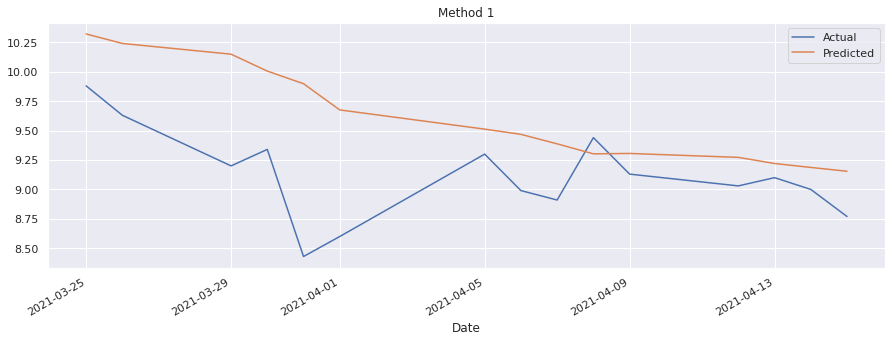

In [38]:
ax = test_df.plot(title="Method 1", x="Date", y="Close",figsize=(15,5))
test_df.plot(ax=ax, x="Date", y="Prediction")

plt.legend(labels=['Actual', 'Predicted'])


In [39]:
# The closer to zero, the better
performanceAvg(test_df, "Close", "Prediction")

0.4019370366915748

### Predicting actual future

In [40]:
# train_df = modified_df[10:].copy()
train_df = modified_df.copy()

In [41]:
features = list(train_df.columns.values)
features.remove("Date")
features.remove("Close")
features

['Close1',
 'Close2',
 'Close3',
 'Close4',
 'Close5',
 'Close6',
 'Close7',
 'Close8',
 'Close9',
 'Close10',
 'Close11',
 'Close12',
 'Close13',
 'Close14',
 'Close15']

In [42]:
target = "Close"

In [43]:
r_values = PCC(train_df, features, target)
print(f"R-value per feature BEFORE kernelazation: {r_values}")

R-value per feature BEFORE kernelazation: [0.9557606835842825, 0.930941202448485, 0.9000298249307525, 0.86597046853793, 0.8437881813348258, 0.8173555877214853, 0.7914623279242532, 0.7743840478258323, 0.7558085128756434, 0.7392426000091042, 0.721465733206778, 0.7073388321246863, 0.6886873482872821, 0.6704874287000839, 0.6538551897137215]


In [44]:
# roc = latestRateOfChange(train_df, "Close", period = 15)
# roc = 1 + roc

In [45]:
# Kernelizing features with values above

# train_df = kernelize(train_df, features, roc)
train_df = kernelize(train_df, features, r_values)

In [46]:
r_values = PCC(train_df, features, target)
print(f"R-value per feature AFTER kernelization: {r_values}")

R-value per feature AFTER kernelization: [0.9570264305651566, 0.9336107661011495, 0.9049061227437186, 0.8741943971542889, 0.8538594586271613, 0.8298084744681744, 0.8052845088097949, 0.7886406460063002, 0.7708460927284501, 0.7554954030340786, 0.7393967479556609, 0.7258388728656946, 0.7092256259754566, 0.6935146909362482, 0.6794832357936359]


In [47]:
train_df.head()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
15,2020-05-07,4.60,4.201375,3.862703,3.685424,3.372025,3.410396,3.338113,3.119577,3.071884,2.872819,2.791708,2.669518,2.628175,2.638069,2.646634,2.479528
16,2020-05-08,4.71,4.299697,4.047650,3.693209,3.507924,3.268651,3.281815,3.213046,3.043926,2.990289,2.807133,2.723629,2.618683,2.562056,2.571300,2.583500
17,2020-05-11,4.58,4.397916,4.139888,3.864036,3.515053,3.396944,3.149600,3.160559,3.133131,2.963724,2.919351,2.738315,2.670714,2.553046,2.499142,2.511762
18,2020-05-12,4.50,4.281828,4.231973,3.949133,3.671352,3.403671,3.269275,3.037183,3.083046,3.048466,2.893983,2.845099,2.684832,2.602423,2.490585,2.442998
19,2020-05-13,4.46,4.210317,4.123129,4.034028,3.749115,3.551058,3.275546,3.148865,2.965242,3.000893,2.974892,2.820968,2.787442,2.615816,2.537469,2.434841


In [48]:
weights, bias = LinearRegression(train_df, features, target)

In [49]:
print("Weights:", weights)
print("Bias:", bias)

Weights: [0.16339147 0.14804058 0.13212575 0.11745368 0.10910038 0.10021734
 0.09243877 0.08794365 0.08336775 0.07971975 0.07604674 0.07335882
 0.06991762 0.06682804 0.0642266 ]
Bias: 0.016986243651468964


In [50]:
new_dates = pd.bdate_range(train_df.Date.iloc[-1] + datetime.timedelta(days=1), periods=period)
test_df = pd.DataFrame(new_dates, columns=["Date"])
test_df = test_df.reset_index(drop=True)

In [51]:
test_df = pd.concat([modified_df[-1:], test_df], ignore_index=True)

In [52]:
test_df.head()

,Date,Close,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
0,2021-04-15,8.77,9.0,9.1,9.03,9.13,9.44,8.91,8.99,9.3,8.6,8.43,9.34,9.2,9.63,9.88,9.58
1,2021-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-04-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
# mean_values = meanRightShift(test_df, "Close1", "Close15")
past_values = list(modified_df.iloc[-1: , 1:period + 1].values[0])
past_values.reverse()
past_values

[9.88,
 9.63,
 9.2,
 9.34,
 8.43,
 8.6,
 9.3,
 8.99,
 8.91,
 9.44,
 9.13,
 9.03,
 9.1,
 9.0,
 8.77]

In [54]:
# test_df = rightShift(test_df, "Close", 14, mean_values)
test_df = rightShift(test_df, "Close", period - 1, past_values)
test_df = test_df.iloc[1:]
test_df["Close"] = modified_df[-period:]["Close"]
test_df = test_df.drop(columns=["Close"])

In [55]:
test_df

,Date,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15
1,2021-04-16,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88
2,2021-04-19,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63
3,2021-04-20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34,9.20
4,2021-04-21,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43,9.34
5,2021-04-22,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60,8.43
6,2021-04-23,8.43,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30,8.60
7,2021-04-26,8.60,8.43,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99,9.30
8,2021-04-27,9.30,8.60,8.43,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91,8.99
9,2021-04-28,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44,8.91
10,2021-04-29,8.91,8.99,9.30,8.60,8.43,9.34,9.20,9.63,9.88,8.77,9.00,9.10,9.03,9.13,9.44


In [56]:
# Kernelizing features with values above
# test_df = kernelize(test_df, features, roc)
test_df = kernelize(test_df, features, r_values)

In [57]:
test_df = predict(test_df, features, weights, bias)

In [58]:
test_df.head()

,Date,Close1,Close2,Close3,Close4,Close5,Close6,Close7,Close8,Close9,Close10,Close11,Close12,Close13,Close14,Close15,Prediction
1,2021-04-16,7.988689,7.778414,7.376365,6.846315,6.608563,6.442286,5.819984,5.651629,5.578935,5.081703,4.836753,5.061922,4.825508,4.810157,4.741554,9.226913
2,2021-04-19,8.953827,7.592671,7.302976,6.892688,6.546709,6.266237,6.097192,5.611929,5.435030,5.391187,4.908684,4.698959,4.877473,4.660162,4.659696,9.330473
3,2021-04-20,8.736880,8.486249,7.133885,6.826427,6.590017,6.209231,5.935431,5.873575,5.397710,5.254859,5.201075,4.767551,4.535453,4.709229,4.517287,9.387764
4,2021-04-21,8.363160,8.285602,7.946239,6.673674,6.528133,6.249146,5.883023,5.720926,5.643563,5.219492,5.072322,5.046178,4.600132,4.386065,4.563882,9.379612
5,2021-04-22,8.484917,7.939674,7.764070,7.406465,6.385415,6.192108,5.919720,5.671451,5.500158,5.452389,5.038909,4.923522,4.862649,4.447218,4.256810,9.385840


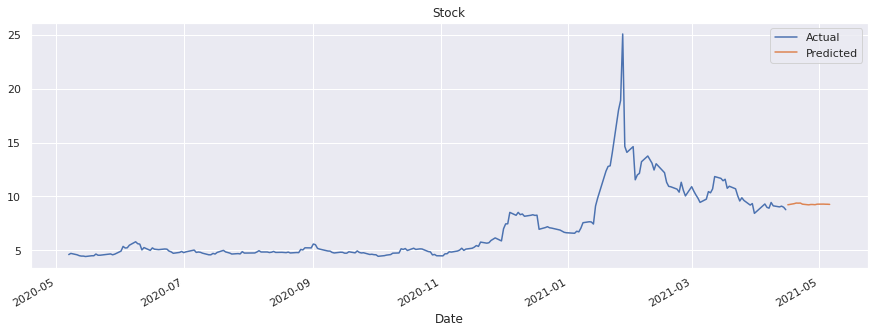

In [59]:
ax = train_df.plot(title="Stock", x="Date", y="Close",figsize=(15,5))
test_df.plot(ax=ax, x="Date", y="Prediction")

plt.legend(labels=['Actual', 'Predicted'])
